In [200]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from scipy.optimize import minimize

# Settings
plt.style.use('ggplot')

In [201]:
# Download and clean the data
risk_free = 0.043 # US 1M Rate (approximate for time notebook was created)
tickers = pd.read_csv('data/SP500.csv')['Symbol'].to_list()

data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)['Close']
data.dropna(axis=1, inplace=True)

[*********************100%***********************]  505 of 505 completed

77 Failed downloads:
['HCN', 'CBG', 'AET', 'CSRA', 'GGP', 'KORS', 'ESRX', 'TWX', 'DPS', 'LUK', 'WYN', 'SCG', 'NFX', 'PCLN', 'SNI', 'ANDV', 'BF.B', 'EVHC']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
['ARNC', 'GPS', 'AGN', 'VIAB', 'PBCT', 'ADS', 'WLTW', 'ANTM', 'RE', 'CHK', 'BHGE', 'APC', 'SYMC', 'MON', 'ETFC', 'BRK.B', 'TMK', 'JEC', 'NBL', 'DISCK', 'ALXN', 'XLNX', 'RHT', 'DWDP', 'HRS', 'FBHS', 'TIF', 'PKI', 'LLL', 'PXD', 'ABC', 'DISH', 'CTL', 'PDCO', 'DISCA', 'ATVI', 'BBT', 'FLIR', 'CELG', 'CXO', 'MYL', 'RTN', 'CBS', 'MRO', 'HCP', 'UTX', 'DRE', 'XEC', 'VAR', 'TSS', 'XL', 'CTXS', 'FISV', 'CERN', 'BLL', 'KSU', 'WRK']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')
['SYY']: Timeout('Failed to perform, curl: (28) Operation timed out after 30010 milliseconds with 0 bytes received. See https://curl.se/l

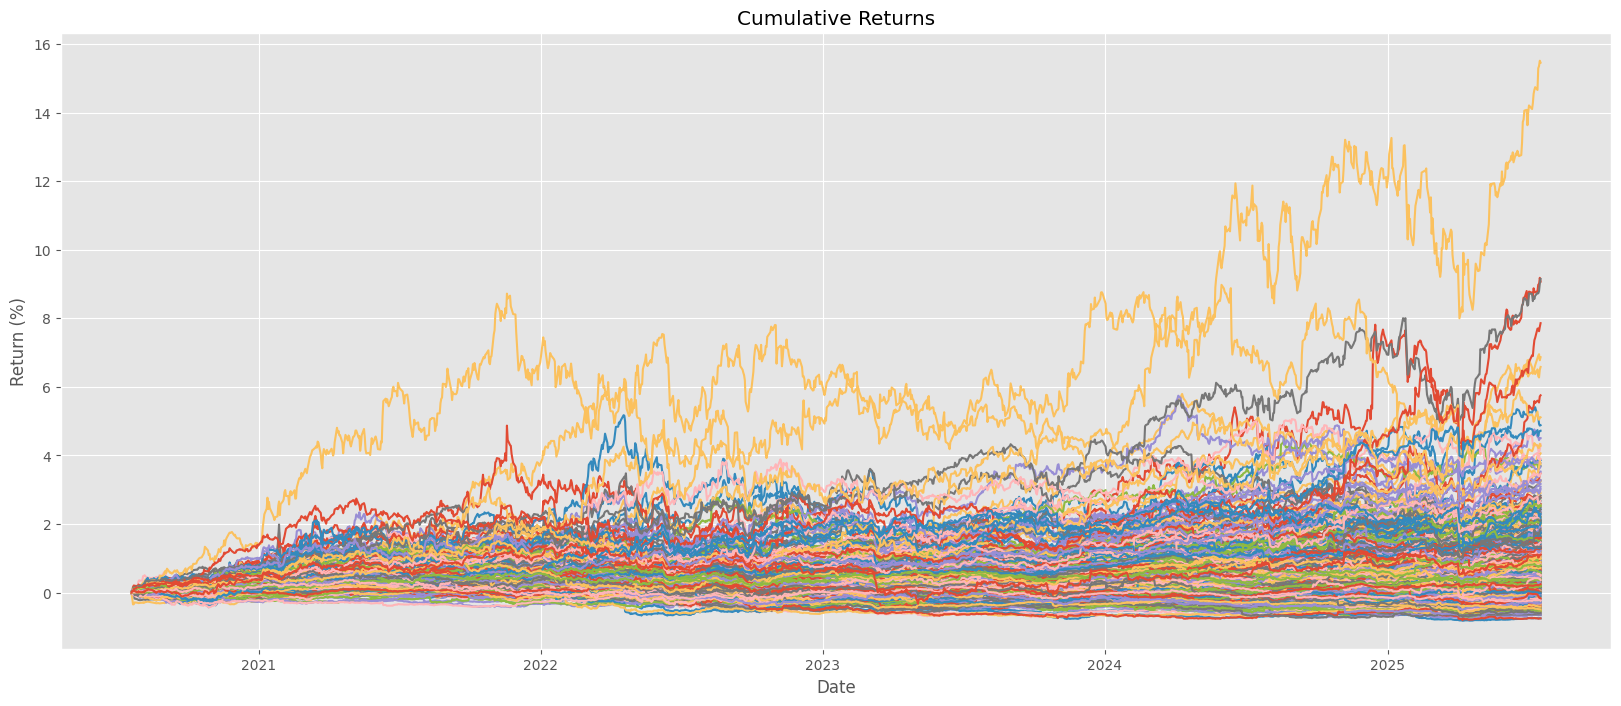

In [202]:
# Calculate the daily returns
returns = data.pct_change()
returns.fillna(0, inplace=True)

log_returns = np.log(data / data.shift(1)).dropna()

cumulative_returns = (1 + returns).cumprod() - 1

plt.figure(figsize=(20, 8))
plt.plot(cumulative_returns)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.show()

In [203]:
def portfolio_er(weights, er):
    """
    * Computes the expected return of the portfolio given the
    * component weights and individual expected returns.
    *
    * weights: list of component weights
    * er: list of expected returns
    * NOTE: index of weights and er must match
    *
    * return: portfolio expected return (E(p))
    """

    return np.dot(np.array(weights), np.array(er))

def portfolio_var(weights, cov_matrix):
    """
    * Computes the variance of the portfolio given the component
    * weights and the covariance matrix.
    *
    * weights: list of component weights
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * NOTE: index of weights and cov_matrix must match
    *
    * return: portfolio variance (Var(p))
    """

    return np.array(weights) @ cov_matrix @ np.array(weights).T

In [204]:
# Objective Function
def negative_sharpe_ratio(weights, returns, cov_matrix):
    """
    * Computes the negative Sharpe ratio for a portfolio of components.
    * The negative factor in this calculation is used to convert the
    * minimzation problem into an maximization problem.
    *
    * returns: list of component expected returns
    * cov_matrix: matrix of covariances between the individual
    *             components; diagonals are variances
    * weights: list of component weights
    * NOTE: index of each input parameter must be equivalent
    *
    * return: negative portfolio Sharpe ratio
    """

    return -(portfolio_er(weights, returns) - risk_free) / np.sqrt(portfolio_var(weights, cov_matrix))

In [205]:
# Mean-Variance Optimization
method = "SLSQP"
weights = [1 / len(log_returns.columns)] * len(log_returns.columns)

# Compute the component covariance matrix and expected returns
covariance_matrix = log_returns.cov() * 252
expected_returns = log_returns.mean() * 252

# Allows for long only positions
# Constraining the net portfolio exposure to 1
constraint = {
    'type' : 'eq',                  # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(w) # Sum of all weights equals 1
}
bounds = [(0, 1)] * len(weights)    # Each weight is between 0 and 1

# Maximization
res = minimize(negative_sharpe_ratio,
               weights,
               args = (expected_returns, covariance_matrix),
               method = method,
               bounds = bounds,
               constraints = [constraint])

Optimized Weights(filtered): {'AVGO': 0.06352400067238549, 'CBOE': 0.08326542160988648, 'GE': 0.04559950638493411, 'HRB': 0.06634742621406708, 'KR': 0.04601826168604697, 'LLY': 0.0891173832928614, 'MCK': 0.2326340272896342, 'MPC': 0.011654065078889077, 'NVDA': 0.038260594980206494, 'ORLY': 0.015869544210474512, 'PGR': 0.02147579808807889, 'PM': 0.1263889600322336, 'PWR': 0.10434614844247585, 'TPR': 0.05549886201315956}
Portfolio Size(filtered): 14
Portfolio Expected Return: 0.3309697478804591
Portfolio Standard Deviation: 0.1527360914634064
Portfolio Sharpe Ratio: 1.885407339688622


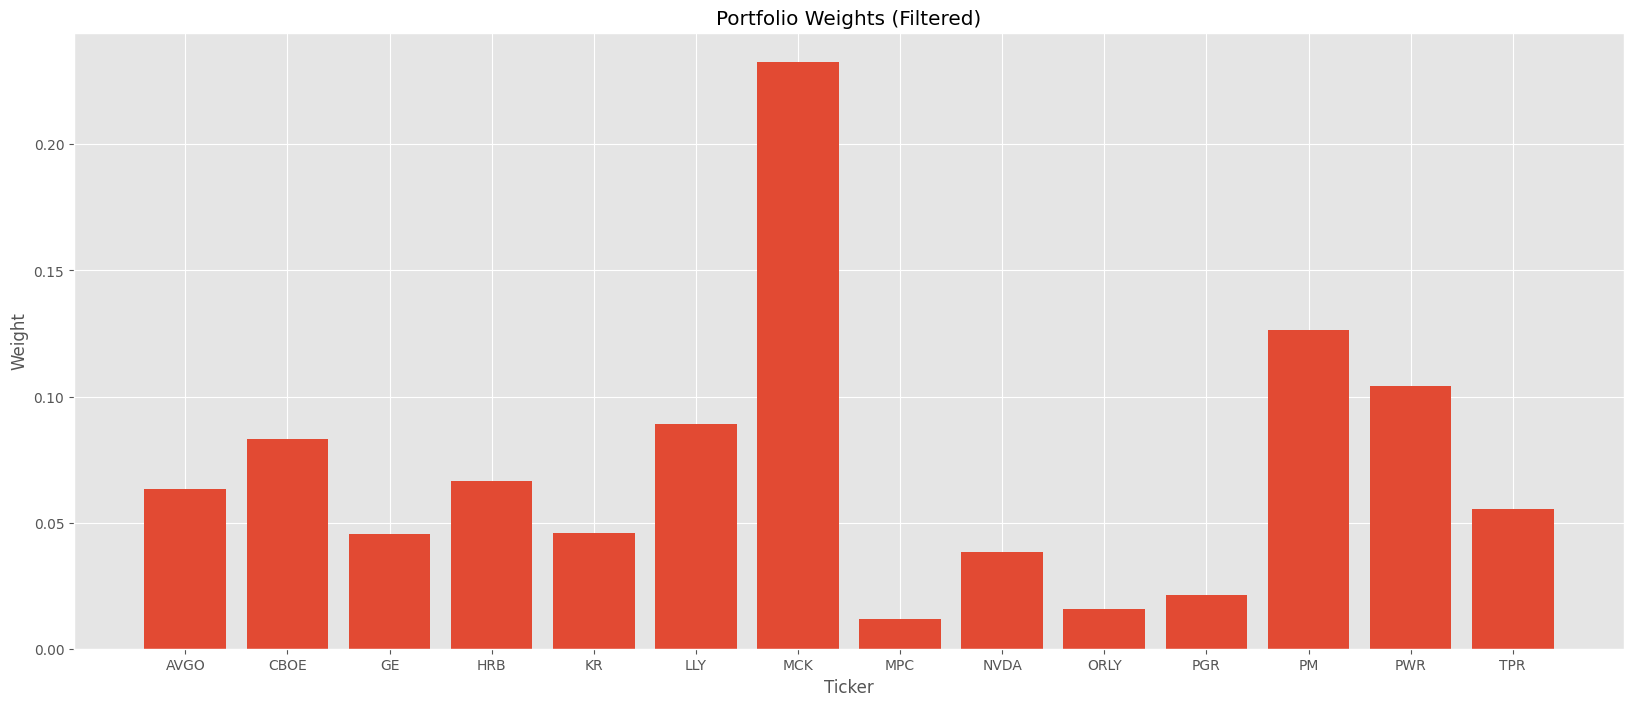

In [206]:
# Extract the optimized weights
optimized_weights = res.x
portfolio_weights = dict(zip(returns.columns, optimized_weights))

# Filter only stocks with a 1% or larger portfolio weight
filtered_weights = {k: v for k, v in portfolio_weights.items() if v >= 0.01}

# Print the results (expected portfolio performance)
print(f'Optimized Weights(filtered): {filtered_weights}')
print(f'Portfolio Size(filtered): {len(filtered_weights)}')
print(f'Portfolio Expected Return: {portfolio_er(res.x, expected_returns)}')
print(f'Portfolio Standard Deviation: {np.sqrt(portfolio_var(res.x, covariance_matrix))}')
print(f'Portfolio Sharpe Ratio: {-negative_sharpe_ratio(res.x, expected_returns, covariance_matrix)}')

# Plot the results
plt.figure(figsize=(20, 8))
plt.bar(filtered_weights.keys(), filtered_weights.values())
plt.title("Portfolio Weights (Filtered)")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.show()

Optimized Weights(filtered): {'AAPL': 0.02633849877268055, 'ABBV': 0.039186970037363704, 'ACN': -0.02385558389395604, 'ADBE': -0.03485979682404031, 'ADI': 0.06587009564018674, 'ADM': -0.013049021901365728, 'AFL': 0.03988630343331781, 'AIG': -0.016685674883112286, 'AIV': 0.03008292054071143, 'AKAM': -0.013568526210105195, 'ALGN': -0.02370419680599243, 'AMAT': -0.05797864607085514, 'AME': -0.021620359348892434, 'AMG': 0.016251813508535794, 'AMGN': 0.020490791532408528, 'AMT': -0.016929938281167057, 'AMZN': -0.026880534590056206, 'AON': -0.013566186220541288, 'AOS': -0.011982069813569283, 'APA': -0.024805786299678816, 'APD': -0.010336558762019492, 'APH': 0.011585647269313375, 'APTV': -0.01844133725147329, 'ARE': -0.038810778085946504, 'AVGO': 0.03702118361066492, 'AVY': 0.02230445843125127, 'AYI': 0.012334354404039616, 'BA': -0.03693863064358042, 'BAC': -0.027805614696844318, 'BAX': -0.028508978089323175, 'BBY': -0.01802682300545106, 'BEN': 0.015853893742138768, 'BHF': -0.0264359593061602

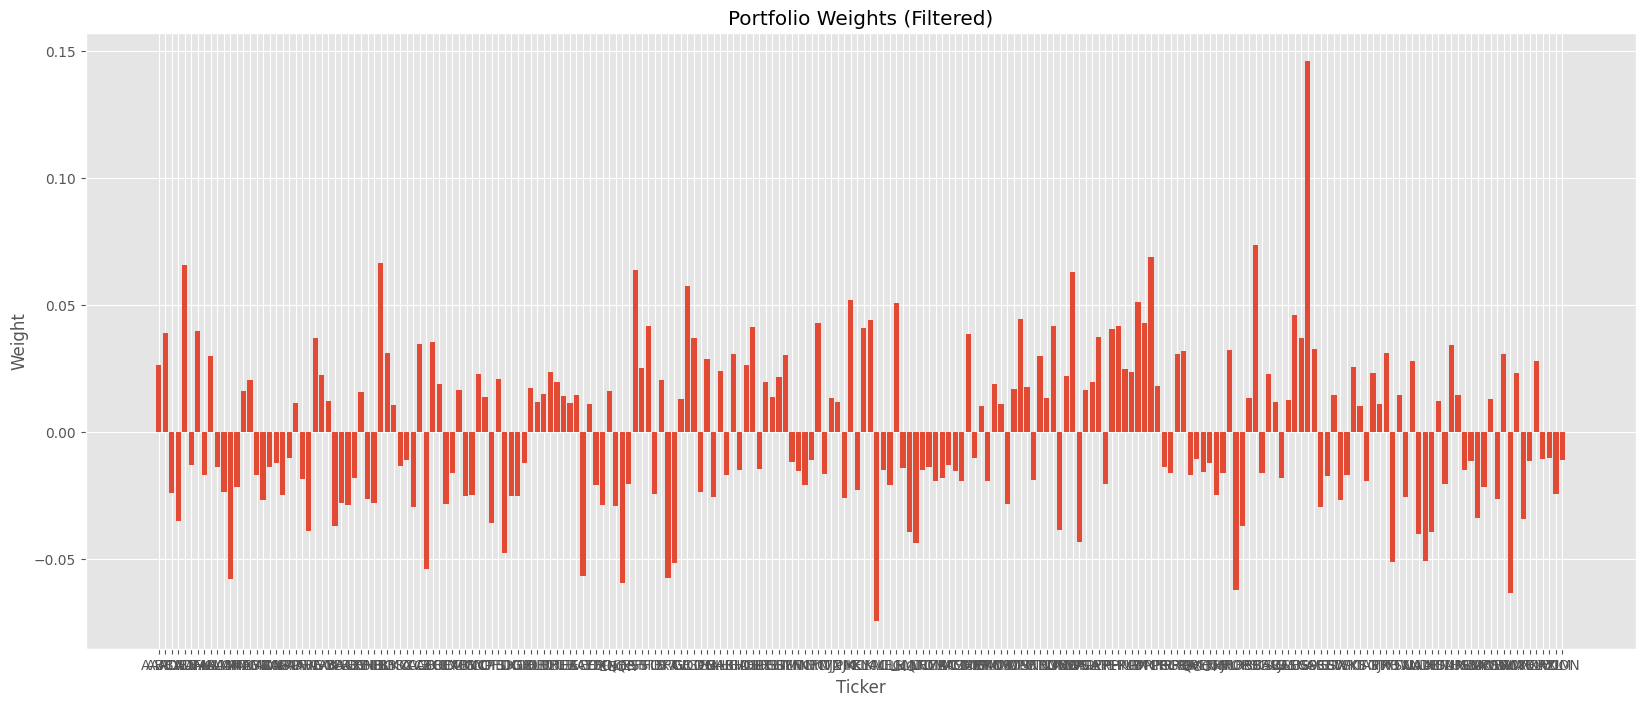

In [207]:
# Allows for long and short positions
# In this instance, we are ensuring the gross portfolio weight is 1
constraint = {
    'type' : 'eq',                       # Equivalency constraint
    'fun' : lambda w: 1 - np.sum(abs(w)) # Sum of all weights equals 1
}
bounds = [(-1, 1)] * len(weights)    # Each weight is between -1 and 1

# Maximization
res = minimize(negative_sharpe_ratio,
               weights,
               args = (expected_returns, covariance_matrix),
               method = method,
               bounds = bounds,
               constraints = [constraint])

# Extract the optimized weights
optimized_weights = res.x
portfolio_weights = dict(zip(returns.columns, optimized_weights))

# Filter only stocks with a 1% or larger portfolio weight
filtered_weights = {k: v for k, v in portfolio_weights.items() if abs(v) >= 0.01}

# Print the results (expected portfolio performance)
print(f'Optimized Weights(filtered): {filtered_weights}')
print(f'Portfolio Size(filtered): {len(filtered_weights)}')
print(f'Portfolio Expected Return: {portfolio_er(res.x, expected_returns)}')
print(f'Portfolio Standard Deviation: {np.sqrt(portfolio_var(res.x, covariance_matrix))}')
print(f'Portfolio Sharpe Ratio: {-negative_sharpe_ratio(res.x, expected_returns, covariance_matrix)}')

# Plot the results
plt.figure(figsize=(20, 8))
plt.bar(filtered_weights.keys(), filtered_weights.values())
plt.title("Portfolio Weights (Filtered)")
plt.xlabel("Ticker")
plt.ylabel("Weight")
plt.show()